In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.1
torch 2.6.0+cpu
cpu


In [2]:
#挂载谷歌云盘
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !cp /content/drive/MyDrive/transformer-de-en/* . -r

## 数据加载

- 采用WMT16的德语和英语平行语料库，数据集主页：[WMT16](https://www.statmt.org/wmt16/multimodal-task.html#task1)

In [4]:
#和jieba分词类似
# !pip install sacremoses
# !pip install subword-nmt
# # BPE分词

In [5]:
# !pwd

In [6]:
# !sh data_multi30k.sh wmt16 wmt16_cut de en

Dataset

In [7]:
from pathlib import Path  # 用于处理文件路径
from torch.utils.data import Dataset, DataLoader  # 导入 PyTorch 数据集和数据加载器

class LangPairDataset(Dataset):
    """
    该类用于加载和处理双语数据集（如德语-英语），并可选择将数据缓存到本地，避免重复处理。
    """
    def __init__(self, mode="train", max_length=128, overwrite_cache=False, data_dir="wmt16"):
        """
        初始化数据集。
        :param mode: 指定数据集模式（"train" 或 "val"）
        :param max_length: 句子的最大长度，超过该长度的句子会被过滤掉
        :param overwrite_cache: 是否覆盖缓存文件，默认为 False
        :param data_dir: 数据存放的目录
        """
        self.data_dir = Path(data_dir)  # 设定数据存储路径
        cache_path = self.data_dir / ".cache" / f"de2en_{mode}_{max_length}.npy"  # 缓存文件路径
        
        if overwrite_cache or not cache_path.exists():  # 如果选择覆盖缓存或缓存文件不存在
            cache_path.parent.mkdir(parents=True, exist_ok=True)  # 创建缓存目录（如果不存在）
            
            # 读取源语言文件（.bpe 文件格式）
            with open(self.data_dir / f"{mode}_src.bpe", "r", encoding="utf8") as file:
                self.src = file.readlines()  # 读取所有行，存入列表
            
            # 读取目标语言文件（.bpe 文件格式）
            with open(self.data_dir / f"{mode}_trg.bpe", "r", encoding="utf8") as file:
                self.trg = file.readlines()  # 读取所有行，存入列表
            
            filtered_src = []  # 存放符合长度要求的源语言句子
            filtered_trg = []  # 存放符合长度要求的目标语言句子
            
            # 遍历源语言和目标语言句子，进行长度过滤
            for src, trg in zip(self.src, self.trg):
                if len(src) <= max_length and len(trg) <= max_length:  # 只保留长度符合要求的句子
                    filtered_src.append(src.strip())  # 去除首尾空格并添加到列表
                    filtered_trg.append(trg.strip())
            
            # 转换为 NumPy 数组
            filtered_src = np.array(filtered_src)
            filtered_trg = np.array(filtered_trg)
            
            # 将过滤后的数据保存为缓存文件
            np.save(cache_path, {"src": filtered_src, "trg": filtered_trg}, allow_pickle=True) # allow_pickle=True 为了保存字典
            print(f"save cache to {cache_path}")  # 提示缓存已保存
        
        else:  # 如果缓存文件存在，则直接加载缓存数据
            cache_dict = np.load(cache_path, allow_pickle=True).item()  # 读取缓存文件
            print(f"load {mode} dataset from {cache_path}")  # 提示数据已加载
            filtered_src = cache_dict["src"]  # 读取源语言数据
            filtered_trg = cache_dict["trg"]  # 读取目标语言数据
        
        self.src = filtered_src  # 存储源语言数据
        self.trg = filtered_trg  # 存储目标语言数据

    def __getitem__(self, index):
        """
        获取索引对应的源语言和目标语言句子。
        :param index: 数据索引
        :return: (源语言句子, 目标语言句子)
        """
        return self.src[index], self.trg[index]  # 返回对应索引的数据

    def __len__(self):
        """
        返回数据集的大小。
        """
        return len(self.src)  # 数据集大小等于源语言句子的数量

# 创建训练集和验证集的数据集对象
train_ds = LangPairDataset("train")  # 训练集
val_ds = LangPairDataset("val")  # 验证集

save cache to wmt16\.cache\de2en_train_128.npy
save cache to wmt16\.cache\de2en_val_128.npy


In [8]:
# !rm wmt16/.cache -r

In [9]:
print(len(train_ds)) # 少了1000多个样本
print("source: {}\ntarget: {}".format(*train_ds[-1]))

27962
source: ein älterer mann sitzt mit einem jungen mit einem wagen vor einer fassade .
target: an elderly man sits outside a storefront accompanied by a young boy with a cart .


### Tokenizer

这里有两种处理方式，分别对应着 encoder 和 decoder 的 word embedding 是否共享，这里实现共享的方案

In [10]:
# 载入词表，看下词表长度，词表就像英语字典, 构建 word2idx 和 idx2word

word2idx = {
    "[PAD]": 0,     # 填充 token，表示句子长度不足时填充的占位符
    "[BOS]": 1,     # 句子起始 token，Begin Of Sentence
    "[UNK]": 2,     # 未知 token，Unknown，表示词表中未收录的词
    "[EOS]": 3,     # 句子结束 token，End Of Sentence
}

# 构建索引到单词的映射，即 idx2word，方便通过索引查找对应单词
idx2word = {value: key for key, value in word2idx.items()}

# 记录当前索引的起始位置，从 4 开始（因为已有 4 个特殊 token）
index = len(idx2word)

# 设定一个阈值，只有出现次数大于等于该阈值的 token 才会加入词表
threshold = 1  

# 读取词表文件，词表文件格式为每行一个单词及其出现次数
with open("wmt16/vocab", "r", encoding="utf8") as file:
    for line in tqdm(file.readlines()):  # 使用 tqdm 显示进度条，适用于大词表
        token, counts = line.strip().split()  # 按空格拆分，每行格式为 "单词 词频"
        if int(counts) >= threshold:  # 只有词频大于等于 threshold 才加入词表
            word2idx[token] = index  # 给该单词分配索引
            idx2word[index] = token  # 反向索引表
            index += 1  # 更新索引计数

# 计算最终词表大小（即 word2idx 的键值对个数）
vocab_size = len(word2idx)
print("vocab_size: {}".format(vocab_size))  # 打印词表大小

  0%|          | 0/18107 [00:00<?, ?it/s]

vocab_size: 18111


In [11]:
class Tokenizer:
    def __init__(self, word2idx, idx2word, max_length=128, pad_idx=0, bos_idx=1, eos_idx=3, unk_idx=2):
        """
        初始化 Tokenizer

        :param word2idx: 单词到索引的映射
        :param idx2word: 索引到单词的映射
        :param max_length: 句子最大长度，超过会被截断，默认 128
        :param pad_idx: 填充 token 的索引，默认为 0（[PAD]）
        :param bos_idx: 句子起始 token 的索引，默认为 1（[BOS]）
        :param eos_idx: 句子结束 token 的索引，默认为 3（[EOS]）
        :param unk_idx: 未知单词的索引，默认为 2（[UNK]）
        """
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.max_length = max_length
        self.pad_idx = pad_idx
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
        self.unk_idx = unk_idx

    def encode(self, text_list, padding_first=False, add_bos=True, add_eos=True, return_mask=False):
        """
        将文本列表编码为索引列表，并进行填充或截断。

        :param text_list: 需要编码的文本列表（每个元素都是分词后的单词列表）
        :param padding_first: 是否在前面填充 [PAD]，默认为 False（即填充在后面）
        :param add_bos: 是否添加 [BOS] 作为起始符号，默认为 True
        :param add_eos: 是否添加 [EOS] 作为结束符号，默认为 True
        :param return_mask: 是否返回 mask（掩码），用于计算损失时忽略 [PAD] 位置
        :return: 若 return_mask=False，则返回编码后的 input_ids；否则返回 (input_ids, masks)
        """

        # 计算句子最大长度，确保不会超过 max_length
        max_length = min(self.max_length, add_eos + add_bos + max([len(text) for text in text_list]))

        indices_list = []  # 存放编码后的索引序列
        for text in text_list:
            # 将单词转换为索引，遇到未登录词（OOV）则替换为 [UNK]
            indices = [self.word2idx.get(word, self.unk_idx) for word in text[:max_length - add_bos - add_eos]]

            # 根据参数，决定是否在索引列表前后添加 [BOS] 和 [EOS]
            if add_bos:
                indices = [self.bos_idx] + indices
            if add_eos:
                indices = indices + [self.eos_idx]

            # 进行填充（padding），使所有句子长度一致
            if padding_first:
                # 在前面填充 [PAD]
                indices = [self.pad_idx] * (max_length - len(indices)) + indices
            else:
                # 在后面填充 [PAD]
                indices = indices + [self.pad_idx] * (max_length - len(indices))

            indices_list.append(indices)  # 加入到结果列表

        # 转换为 PyTorch 张量
        input_ids = torch.tensor(indices_list)

        # 生成 mask，填充部分（[PAD]）标记为 1，其余部分标记为 0
        masks = (input_ids == self.pad_idx).to(dtype=torch.int64)

        # 返回编码后的 input_ids，或 (input_ids, masks)
        return input_ids if not return_mask else (input_ids, masks)

    def decode(self, indices_list, remove_bos=True, remove_eos=True, remove_pad=True, split=False):
        """
        将索引列表解码回文本列表。

        :param indices_list: 需要解码的索引列表（可包含多个句子）
        :param remove_bos: 是否移除 [BOS] 令牌，默认为 True
        :param remove_eos: 是否移除 [EOS] 令牌，默认为 True
        :param remove_pad: 是否移除 [PAD] 令牌，默认为 True
        :param split: 是否返回分词后的列表，默认为 False（即返回拼接后的字符串）
        :return: 处理后的文本列表
        """
        text_list = []  # 存放解码后的文本
        for indices in indices_list:
            text = []  # 存放当前句子的单词
            for index in indices:
                word = self.idx2word.get(index, "[UNK]")  # 通过索引获取单词，未知索引替换为 [UNK]

                # 按参数决定是否移除特殊 token
                if remove_bos and word == "[BOS]":
                    continue
                if remove_eos and word == "[EOS]":
                    break  # [EOS] 之后的内容无需处理，直接跳出循环
                if remove_pad and word == "[PAD]":
                    break  # [PAD] 之后的内容无需处理，直接跳出循环

                text.append(word)  # 添加单词到当前句子

            # 根据 split 参数决定返回格式：
            # - 若 split=False，则返回完整的句子字符串（单词以空格拼接）
            # - 若 split=True，则返回单词列表
            text_list.append(" ".join(text) if not split else text)

        return text_list  # 返回解码后的文本列表

# 创建 Tokenizer 实例
tokenizer = Tokenizer(word2idx=word2idx, idx2word=idx2word)

In [12]:
# 例子：准备输入数据，模拟分词后的文本列表
raw_text = [
    "hello world".split(),
    "tokenize text datas with batch".split(),
    "this is a test".split()
]

# 对输入文本进行编码
indices = tokenizer.encode(raw_text, padding_first=False, add_bos=True, add_eos=True)

# 对编码结果进行解码
decode_text = tokenizer.decode(indices.tolist(), remove_bos=False, remove_eos=False, remove_pad=False)

# 打印原始文本
print("raw text")
for raw in raw_text:
    print(raw)

# 打印编码后的索引序列
print("indices")
for index in indices:
    print(index)

# 打印解码后的文本
print("decode text")
for decode in decode_text:
    print(decode)

raw text
['hello', 'world']
['tokenize', 'text', 'datas', 'with', 'batch']
['this', 'is', 'a', 'test']
indices
tensor([   1, 9458, 3522,    3,    0,    0,    0])
tensor([   1,    2, 5463,    2,   22,    2,    3])
tensor([   1,  385,   18,    5, 5699,    3,    0])
decode text
[BOS] hello world [EOS] [PAD] [PAD] [PAD]
[BOS] [UNK] text [UNK] with [UNK] [EOS]
[BOS] this is a test [EOS] [PAD]


In [13]:
# 例子：检查 train_ds 数据集中源语言 (i) 和目标语言 (j) 句子的长度
for i,j in train_ds:
    print(len(i))
    print(len(j))
    break

66
54


### Transformer Batch Sampler

> Sentence pairs were batched together by approximate sequence length. Each training batch contained a set of sentence pairs containing approximately 25000 source tokens and 25000 target tokens
句子按照序列长度差不多的分到一个批次。 每个训练批次包含一组句子对，其中包含大约 25000 个源标记和 25000 个目标标记

In [14]:
# 动态划分batch
class SampleInfo:  # 下面的 info 对象
    def __init__(self, i, lens):
        """
        记录文本对的序号和长度信息
        输入：
            - i (int): 文本对的序号。
            - lens (list): 文本对源语言和目标语言的长度
        """
        self.i = i  # 记录当前文本对的序号
        # 计算当前样本的最大长度，+1 是为了考虑填补在文本前后的特殊词元
        self.max_len = max(lens[0], lens[1]) + 1
        # 计算源语言文本的长度（包含特殊词元）
        self.src_len = lens[0] + 1
        # 计算目标语言文本的长度（包含特殊词元）
        self.trg_len = lens[1] + 1

# 一个批量生成器，根据词元数目的限制来控制批量的大小。
# 它会根据传入的样本信息，在不超过设定大小的情况下，逐步构建批量。
class TokenBatchCreator:
    def __init__(self, batch_size):
        """
        参数:
        batch_size (int): 用于限制批量的大小。
        
        功能:
        - 初始化一个空的批量列表 `_batch`，用于存储当前批次的样本。
        - 设定 `max_len` 初始值为 -1，用于记录当前批量中最长样本的长度。
        - 存储传入的 `batch_size`，用于限制当前批次的最大 token 数量。
        """
        self._batch = []  # 当前批次存储的样本列表
        self.max_len = -1  # 当前批次最大样本长度，初始值设为 -1
        self._batch_size = batch_size  # 批量大小的限制，例如 4096

    def append(self, info: SampleInfo):
        """
        向当前批量中添加一个样本，并控制批量大小。
        
        参数:
        - info (SampleInfo): 需要添加的样本信息对象，包含文本对的长度信息。

        逻辑:
        1. 计算当前样本的长度 `cur_len`。
        2. 更新当前批量的最大样本长度 `max_len`。
        3. 检查如果当前批量的 token 数量（`max_len * 样本数`）超过 `_batch_size`：
           - 返回当前批量（表示该批量已经满了）。
           - 清空 `_batch` 并将当前样本作为新批量的第一个样本。
           - `max_len` 设为当前样本的长度。
        4. 否则，将该样本添加到当前批量，并更新 `max_len`。

        返回:
        - 如果批量已满，则返回当前批量，并开启新的批量存储新样本。
        - 如果批量未满，则返回 `None`。
        """
        cur_len = info.max_len  # 当前样本的最大长度
        max_len = max(self.max_len, cur_len)  # 更新当前批量的最大样本长度

        # 计算当前批量的 token 数量（最大长度 * 样本数），如果超过 batch_size，则返回当前批量
        if max_len * (len(self._batch) + 1) > self._batch_size:
            self._batch, result = [], self._batch  # 保存当前批量，并清空 `_batch`
            self._batch.append(info)  # 将当前样本作为新批量的第一个样本
            self.max_len = cur_len  # 设定新批量的最大样本长度
            return result  # 返回已满的批量
        else:
            self.max_len = max_len  # 更新最大样本长度
            self._batch.append(info)  # 添加样本到当前批量
            return None  # 当前批量未满，返回 None

    @property # @property装饰器可以让方法像属性一样被调用
    def batch(self):
        """返回当前批量中存储的样本列表"""
        return self._batch

In [15]:
from torch.utils.data import BatchSampler

class TransformerBatchSampler(BatchSampler): # 继承自 BatchSampler
    def __init__(self,
                 dataset,
                 batch_size,
                 shuffle_batch=False,
                 clip_last_batch=False,
                 seed=0):
        """
        Transformer 训练的批量采样器，用于根据 token 数量进行批量划分。
        
        输入:
            - dataset: 数据集，包含多个文本对，每个文本对包含源语言和目标语言的文本。
            - batch_size: 设定的批量大小（以 token 计算）。
            用于随机的参数：
            - shuffle_batch: 是否对生成的批次进行洗牌（即打乱批次的顺序）。
            - clip_last_batch: 是否丢弃最后一个未达到 batch_size 的批次。
            - seed: 随机种子，用于确保每次运行的洗牌结果相同。
        
        逻辑:
        1. 记录传入的参数，初始化随机数生成器（用于洗牌）。
        2. 遍历数据集中的每个样本，计算其源语言和目标语言的 token 长度。
        3. 创建 `SampleInfo` 对象，存储每个样本的索引及长度信息，并存入 `_sample_infos` 列表。
        """

        self._dataset = dataset  # 数据集:train_ds
        self._batch_size = batch_size  # 设定的最大批量大小（以 token 数量计算） 假设为4096
        self._shuffle_batch = shuffle_batch  # 是否对批次顺序进行随机洗牌
        self._clip_last_batch = clip_last_batch  # 是否裁剪最后不足 batch_size 的批次
        self._seed = seed  # 随机种子，确保每次打乱的顺序一致

        # 初始化 NumPy 随机数生成器
        self._random = np.random
        self._random.seed(seed)

        # 存储所有样本的信息
        self._sample_infos = []  
        
        # 遍历数据集，计算每个样本的源语言和目标语言长度，并存入 SampleInfo 对象
        for i, data in enumerate(self._dataset): # enumerate() 函数用于遍历数据集，返回索引和数据
            lens = [len(data[0]), len(data[1])]  # 计算源语言和目标语言的长度
            self._sample_infos.append(SampleInfo(i, lens))  # 记录样本的索引和长度信息

    def __iter__(self):
        """
        生成批量索引，用于训练数据的采样。
        
        逻辑:
        1. 先按样本的源语言长度排序，若相同再按目标语言长度排序，使得相似长度的样本聚合在一起，减少填充（padding）。
        2. 依次将样本放入 `TokenBatchCreator` 进行分批，保证每批的 token 数量不超过 batch_size。
        3. 若 `clip_last_batch` 为 False，则保留最后不足 batch_size 的批次。
        4. 若 `shuffle_batch` 为 True，则打乱所有批次的顺序。
        5. 逐个返回批次，每个批次包含多个样本的索引，表示数据集中哪些样本属于该批次。

        返回:
        - 迭代器，每次返回一个批次的样本索引列表（如 [0,1,2,...,83]）。
        """

        # 按照 (src_len, trg_len) 进行排序，使得相似长度的样本排列在一起，减少填充需求
        infos = sorted(self._sample_infos, key=lambda x: (x.src_len, x.trg_len))

        batch_infos = []  # 存储所有批次的信息
        batch_creator = TokenBatchCreator(self._batch_size)  # 初始化批量生成器

        # 遍历排序后的样本信息，并放入批量生成器
        for info in infos:
            batch = batch_creator.append(info)  # 添加样本到当前批次
            if batch is not None:
                batch_infos.append(batch)  # 当前批次已满，存储该批次

        # 处理最后一个批次
        if not self._clip_last_batch and len(batch_creator.batch) != 0:
            batch_infos.append(batch_creator.batch)  # 将剩余样本作为最后一个批次

        # 是否对批次进行洗牌（即打乱批次顺序，而不是打乱样本顺序）
        if self._shuffle_batch:
            self._random.shuffle(batch_infos)

        self.batch_number = len(batch_infos)  # 计算总批次数量

        # 依次返回每个批次的样本索引
        for batch in batch_infos:
            batch_indices = [info.i for info in batch]  # 提取该批次所有样本在数据集中的索引
            yield batch_indices  # 生成该批次的索引列表

    def __len__(self):
        """
        返回批次数量（即数据集被划分成了多少个批次）。
        
        逻辑:
        - 若 `batch_number` 已计算，则直接返回。
        - 否则，计算数据集中样本总数与 batch_size 的比值，得到批次数量（一般情况下不会走到这个逻辑）。
        """
        if hasattr(self, "batch_number"):
            return self.batch_number

        # 计算批次数量（一般情况下不会用到此计算逻辑）
        batch_number = (len(self._dataset) + self._batch_size) // self._batch_size
        return batch_number

# 长度*batch_number>4096的时候，就会返回上一个batch，然后新的样本加入新的batch,具体要看TokenBatchCreator的44行代码
sampler = TransformerBatchSampler(train_ds, batch_size=4096, shuffle_batch=True)

In [16]:
# 例子：打印一个批次的样本索引
for idx, batch in enumerate(sampler):
    print("第{}批量的数据中含有文本对是：{}，数量为：{}".format(idx, batch, len(batch)))
    if idx >= 3:
        break

第0批量的数据中含有文本对是：[26845, 982, 1864, 3222, 4716, 5341, 5897, 6103, 8531, 10067, 11125, 13063, 14929, 15158, 18063, 18502, 20661, 20986, 21320, 22030, 22882, 23567, 24909, 1881, 2268, 4268, 7413, 10166, 12447, 13573, 15332, 16727, 17657, 20829, 21508, 23094, 24274, 25801, 518, 2145, 4111, 4739, 4745, 7493, 7623, 8369, 8618, 8730, 9054, 9391, 9808, 10141, 10412, 11422, 13534, 15038]，数量为：56
第1批量的数据中含有文本对是：[26442, 4512, 5035, 5744, 9615, 15349, 15924, 17523, 18557, 5893, 23488, 8119, 10028, 10369, 15787, 26183, 1414, 3099, 19840, 23914, 5354, 8006, 23772, 6689, 27235, 6203, 26078, 8993, 19012, 3375, 19795, 27173, 15729, 4701, 25842, 11235, 18198, 26926, 17825]，数量为：39
第2批量的数据中含有文本对是：[25439, 26265, 6121, 25746, 4051, 9494, 22243, 22632, 23242, 26771, 6762, 7707, 7721, 16134, 19469, 20129, 26029, 19461, 8066, 20314, 24428, 7135, 8517, 14829, 21864, 25671, 27693, 188, 3297, 27196, 27911, 18016, 23408, 16925, 21655, 26323, 3236, 18946, 19307, 11442, 1346, 20842]，数量为：42
第3批量的数据中含有文本对是：[560, 880, 42

In [17]:
len(sampler)

527

### DataLoader

In [18]:
def collate_fct(batch, tokenizer):
    """
    处理一个批次的数据，将其转化为模型输入所需要的格式。
    
    输入：
        - batch: 由多个样本（文本对）组成的批次。每个样本是一个包含源语言和目标语言的元组 `(src_text, trg_text)`。
        - tokenizer: 用于对源语言和目标语言文本进行编码的分词器。

    输出：
        返回一个字典，包含处理后的 encoder 和 decoder 的输入及标签。
    """
    
    # 将批次中的每个文本对的源语言和目标语言分开，按空格分词
    src_words = [pair[0].split() for pair in batch]  # 列表中的每个元素是源语言分词后的单词列表
    trg_words = [pair[1].split() for pair in batch]  # 列表中的每个元素是目标语言分词后的单词列表

    # 对源语言进行编码，添加 [BOS] (开始标记)、[EOS] (结束标记) 并进行填充
    encoder_inputs, encoder_inputs_mask = tokenizer.encode(
        src_words, 
        padding_first=False,  # 填充在序列末尾（前填充设为 False）
        add_bos=True,         # 添加开始标记 [BOS]
        add_eos=True,         # 添加结束标记 [EOS]
        return_mask=True      # 返回对应的 mask（用于标识有效单词位置）
    )

    # 对目标语言进行编码，添加 [BOS] 标记，未添加 [EOS]，不返回 mask
    decoder_inputs = tokenizer.encode(
        trg_words, 
        padding_first=False,  # 填充在序列末尾
        add_bos=True,         # 添加开始标记 [BOS]
        add_eos=False,        # 不添加结束标记 [EOS]
        return_mask=False     # 不需要返回 mask
    )

    # 对目标语言进行编码，添加 [EOS]，未添加 [BOS]，并返回 mask
    decoder_labels, decoder_labels_mask = tokenizer.encode(
        trg_words, 
        padding_first=False,  # 填充在序列末尾
        add_bos=False,        # 不添加开始标记 [BOS]
        add_eos=True,         # 添加结束标记 [EOS]
        return_mask=True      # 返回 mask
    )

    # 将处理后的结果转移到设备（如 GPU）上
    return {
        "encoder_inputs": encoder_inputs.to(device=device),                # 源语言编码
        "encoder_inputs_mask": encoder_inputs_mask.to(device=device),      # 源语言的 mask
        "decoder_inputs": decoder_inputs.to(device=device),                # 目标语言编码（不包含 [EOS]）
        "decoder_labels": decoder_labels.to(device=device),                # 目标语言标签（包含 [EOS]）
        "decoder_labels_mask": decoder_labels_mask.to(device=device),      # 目标语言标签的 mask
    }

In [19]:
from functools import partial  # 固定collate_fct的tokenizer参数

# 创建一个 TransformerBatchSampler 实例，用于控制批量采样的行为。
# batch_size: 批量大小，指定每个批次中的样本数（这里设为128）。
# shuffle_batch: 是否打乱批次，设为True表示打乱批次顺序。
# https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
# 可以调大batch_size,来看最终的bleu，如果GPU内存不够，可以减小batch_size
sampler = TransformerBatchSampler(train_ds, batch_size=256, shuffle_batch=False)

# 使用 DataLoader 创建一个数据加载器，管理数据的批量处理。
# - train_ds: 数据集对象，通常是训练集。
# - batch_sampler: 使用之前创建的 TransformerBatchSampler，来控制批量的生成。
# - collate_fn: 批量处理函数，这里使用 partial 固定了 collate_fct 函数的 tokenizer 参数。
# 这样可以避免每次都手动传递 tokenizer，而是将其固定为一个参数。
sample_dl = DataLoader(train_ds, batch_sampler=sampler, collate_fn=partial(collate_fct, tokenizer=tokenizer))

In [20]:
# 例子：查看一个批次的索引列表
for i in sampler: # 因为TransformerBatchSampler中实现了__iter__方法，所以可以直接用for循环来遍历
    print(f"批次的索引列表为:{i}")
    print(f"批次中的样本数量为:{len(i)}")
    break

批次的索引列表为:[16049, 16193, 8575, 8984]
批次中的样本数量为:4


In [21]:
# 例子：使用 DataLoader 迭代批次
for batch in sample_dl:  # 外层循环遍历每个批次
    for key, value in batch.items():  # 内层循环遍历每个批次字典中的键值对
        print(key)   # 打印批次中的键（例如 "encoder_inputs", "decoder_inputs" 等）
        print(value) # 打印批次中的值，通常是 Tensor 或 numpy 数组
    break  # 只打印第一个批次

encoder_inputs
tensor([[   1, 9771, 9771,    3,    0,    0],
        [   1, 9771, 9771,    3,    0,    0],
        [   1,    7,   17, 9015,    4,    3],
        [   1,   25,   74, 2571,    4,    3]])
encoder_inputs_mask
tensor([[0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]])
decoder_inputs
tensor([[    1,    75,  8631,   471,   300,  2038,  5790,   216,  1354, 10332,
             4],
        [    1,    38,   193, 10092,  3577, 10479,   130,  7302,  4187,     4,
             0],
        [    1,     5,    16,    18,   305,     5,  6510,     4,     0,     0,
             0],
        [    1,    26,   210,    18,    63,     5,  2571,     4,     0,     0,
             0]])
decoder_labels
tensor([[   75,  8631,   471,   300,  2038,  5790,   216,  1354, 10332,     4,
             3],
        [   38,   193, 10092,  3577, 10479,   130,  7302,  4187,     4,     3,
             0],
        [    5,    16,    18,   305,     5,  6510,     4,   

## 定义模型

- Transformer模型由Embedding、Transformer-Block组成
- Embedding包括：
    - WordEmbedding
    - PositionEmbedding
- Transformer-Block包括：
    - Self-Attention
    - Cross-Attention
    - MLP

### Embedding

In [22]:
torch.arange(0, 128).unsqueeze(1).shape

torch.Size([128, 1])

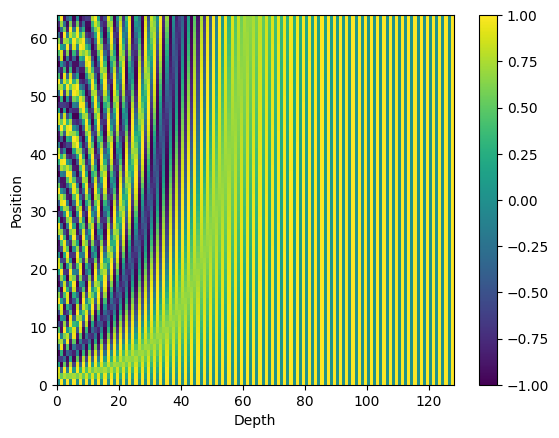

In [23]:
class TransformerEmbedding(nn.Module):
    def __init__(self, config):
        super().__init__()
        # 从配置中获取超参数
        self.vocab_size = config["vocab_size"]  # 词汇表的大小
        self.hidden_size = config["d_model"]  # 词向量的维度
        self.pad_idx = config["pad_idx"]  # padding的索引
        dropout_rate = config["dropout"]  # dropout的比率
        self.max_length = config["max_length"]  # 序列的最大长度

        # 初始化词嵌入层，padding_idx表示pad的词向量全为0
        self.word_embedding = nn.Embedding(self.vocab_size, self.hidden_size, padding_idx=self.pad_idx)
        # 初始化位置嵌入层，_weight表示直接给位置编码的权重
        self.pos_embedding = nn.Embedding(
            self.max_length, 
            self.hidden_size,
            #位置编码，权重通过get_positional_encoding函数计算得到
            _weight=self.get_positional_encoding(self.max_length, self.hidden_size), 
        )
        self.pos_embedding.weight.requires_grad_(False)  # 位置编码的权重不需要更新
        self.dropout = nn.Dropout(dropout_rate)  # 随机失活层

    def get_word_embedding_weights(self):
        # 获取词嵌入层的权重
        return self.word_embedding.weight

    @classmethod
    def get_positional_encoding(self, max_length, hidden_size):
        """
        计算位置编码：通过正弦和余弦函数生成位置编码矩阵
        输入：
            max_length: 最大序列长度
            hidden_size: 词向量维度
        输出：
            pe: 位置编码矩阵
        """
        # 初始化一个零矩阵，大小为(max_length, hidden_size)
        pe = torch.zeros(max_length, hidden_size)
        
        # position是一个大小为(max_length, 1)的张量，包含从0到max_length-1的整数
        position = torch.arange(0, max_length).unsqueeze(1)  # 位置信息，从0到max_length-1
        # div_term计算每个位置的缩放因子，目的是通过对数空间进行归一化
        div_term = torch.exp(
            torch.arange(0, hidden_size, 2)
            * -(torch.log(torch.Tensor([10000.0])) / hidden_size)
        )
        # 对位置编码矩阵进行填充
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶数列填充sin值
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇数列填充cos值
        
        return pe

    def forward(self, input_ids):
        """
        前向传播：将输入的id转换为词向量和位置编码的加和
        输入：
            input_ids: 形状为[batch_size, seq_len]的张量，包含输入序列的id
        输出：
            embeds: 形状为[batch_size, seq_len, hidden_size]的张量，词向量和位置编码的加和
        """
        seq_len = input_ids.shape[1]  # 获取序列的长度
        # 检查输入序列的长度是否超出最大长度
        assert (
            seq_len <= self.max_length
        ), f"input sequence length should no more than {self.max_length} but got {seq_len}"

        # 生成位置id
        position_ids = torch.arange(seq_len, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        # print(position_ids)  # 调试输出位置id

        # 词嵌入：将input_ids转换为词向量
        word_embeds = self.word_embedding(input_ids)
        # 位置嵌入：将position_ids转换为位置编码
        pos_embeds = self.pos_embedding(position_ids)
        # 将词向量和位置编码相加
        embeds = word_embeds + pos_embeds
        # 使用dropout进行随机失活
        embeds = self.dropout(embeds)

        return embeds


def plot_position_embedding(position_embedding):
    """
    绘制位置编码矩阵
    输入：
        position_embedding: 位置编码矩阵
    输出：
        无
    """
    plt.pcolormesh(position_embedding)  # 绘制位置编码矩阵
    plt.xlabel('Depth')  # x轴为深度
    plt.ylabel('Position')  # y轴为位置
    plt.colorbar()  # 添加颜色条，表示编码值的范围
    plt.show()  # 显示图像

# 获取64个位置、128维词向量的位置编码矩阵并绘制
position_embedding = TransformerEmbedding.get_positional_encoding(64, 128)
plot_position_embedding(position_embedding)

In [24]:
# 例子：为了理解指数对数变换
import math
def positional_encoding_weights(emb_size):
    # 计算底数和指数
    base = math.log(10000)
    exponent = -5 / emb_size
    
    # 应用指数函数
    weight = math.exp(exponent*base) 
    
    return weight

emb_size = 10  # 举例，可以替换成你需要的大小
weight = positional_encoding_weights(emb_size)
print(weight)

0.009999999999999995


In [25]:
1/10000**(1/2)

0.01

In [26]:
#例子：随机input，调用TransformerEmbedding
config={
    "vocab_size": 100,
    "d_model": 128,
    "pad_idx": 0,
    "max_length": 64,
    "dropout": 0.1,
}
input_ids = torch.randint(0, 100, (2, 50))
embeds = TransformerEmbedding(config)(input_ids)
embeds.shape

torch.Size([2, 50, 128])

### Transformer Block

#### scaled-dot-product-attention

In [27]:
from dataclasses import dataclass
from typing import Optional, Tuple

# 定义 AttentionOutput 数据类，用于存储多头注意力的输出
Tensor = torch.Tensor
@dataclass
class AttentionOutput:
    hidden_states: Tensor  # 注意力层的最终输出
    attn_scores: Tensor    # 计算得到的注意力权重

# 多头注意力层
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        # 获取配置中的超参数
        self.hidden_size = config["d_model"]  # 隐藏层维度（例如 512）
        self.num_heads = config["num_heads"]  # 头的数量（例如 8）
        
        # 断言，确保 hidden_size 可以被 num_heads 整除
        assert (
            self.hidden_size % self.num_heads == 0
        ), "Hidden size must be divisible by num_heads but got {} and {}".format(
            self.hidden_size, self.num_heads
        )

        # 计算每个头的维度（head_dim = hidden_size / num_heads）
        self.head_dim = self.hidden_size // self.num_heads  

        # 定义线性变换层，将输入的 query、key、value 投影到 hidden_size 维度
        self.Wq = nn.Linear(self.hidden_size, self.hidden_size, bias=False)  # Q 投影层
        self.Wk = nn.Linear(self.hidden_size, self.hidden_size, bias=False)  # K 投影层
        self.Wv = nn.Linear(self.hidden_size, self.hidden_size, bias=False)  # V 投影层
        self.Wo = nn.Linear(self.hidden_size, self.hidden_size, bias=False)  # 输出投影层

    def _split_heads(self, x: Tensor) -> Tensor:
        """
        将输入张量 x 拆分为多个头的形式
        输入: x -> 形状为 [batch_size, seq_len, hidden_size]
        输出: num_heads * head_dim = hidden_size -> [batch_size, seq_len, num_heads, head_dim] 
        """
        bs, seq_len, _ = x.shape  # 获取 batch_size 和序列长度
        x = x.view(bs, seq_len, self.num_heads, self.head_dim)  # 变形，使得每个头拥有 head_dim 维度
        return x.permute(0, 2, 1, 3)  # 交换维度，调整为 [batch_size, num_heads, seq_len, head_dim]

    def _merge_heads(self, x: Tensor) -> Tensor:
        """
        将多个头的注意力结果合并回一个张量
        输入: [batch_size, num_heads, seq_len, head_dim]
        输出: [batch_size, seq_len, hidden_size]
        """
        bs, _, seq_len, _ = x.shape  # 获取 batch_size 和序列长度
        return x.permute(0, 2, 1, 3).reshape(bs, seq_len, self.hidden_size)  # 重新排列维度并恢复原形状

    def forward(self, querys, keys, values, attn_mask=None) -> AttentionOutput: # -> 表示返回值类型
        """
        前向传播计算注意力机制
        输入:
            querys: [batch_size, seq_len, hidden_size]
            keys:   [batch_size, seq_len, hidden_size]
            values: [batch_size, seq_len, hidden_size]
            attn_mask: [batch_size, 1, seq_len, seq_len] (可选)
        输出:
            AttentionOutput(hidden_states=[batch_size, seq_len, hidden_size], attn_scores=[batch_size, num_heads, seq_len, seq_len])
        """

        # 线性变换获取 Q、K、V，并拆分为多个头
        querys = self._split_heads(self.Wq(querys))  # [batch_size, num_heads, seq_len, head_dim]
        keys = self._split_heads(self.Wk(keys))      # [batch_size, num_heads, seq_len, head_dim]
        values = self._split_heads(self.Wv(values))  # [batch_size, num_heads, seq_len, head_dim]

        # 计算 Q 和 K 之间的点积注意力分数，两个张量相乘只会对最后两个维度进行计算 [seq_len, head_dim] x [head_dim, seq_len] = [seq_len, seq_len]
        qk_logits = torch.matmul(querys, keys.mT)  # [batch_size, num_heads, seq_len, seq_len]

        # 如果提供了注意力 mask，则应用它
        if attn_mask is not None:
            attn_mask = attn_mask[:, :, : querys.shape[-2], : keys.shape[-2]]  # 调整 mask 尺寸
            qk_logits += attn_mask * -1e9  # 将需要 mask 的部分赋值为负无穷

        # 计算注意力权重（Softmax 归一化）
        # dim等于那个维度，就是把那个维度给消除了，比如说shape=(2,3,4),如果dim=0,最后的结果的shape=(3,4),如果dim=1,最后的结果的shape=(2,4)，如果dim=2的话，最后的结果的shape=(2,3)
        attn_scores = F.softmax(qk_logits / (self.head_dim**0.5), dim=-1)  # [batch_size, num_heads, seq_len, seq_len]

        # 计算注意力加权求和 [seq_len, seq_len] x [seq_len, head_dim] = [seq_len, head_dim]
        embeds = torch.matmul(attn_scores, values)  # [batch_size, num_heads, seq_len, head_dim]

        # 重新合并多头的输出 [batch_size, num_heads, seq_len, hidden_dim] -> [batch_size, seq_len, hidden_size]
        embeds = self.Wo(self._merge_heads(embeds))  # [batch_size, seq_len, hidden_size]

        # 返回注意力输出
        return AttentionOutput(hidden_states=embeds, attn_scores=attn_scores)

In [28]:
# 例子：测试 MultiHeadAttention
mha = MultiHeadAttention({"num_heads": 2, "d_model": 2})  # 创建多头注意力实例
query = torch.randn(2, 3, 2)  # [batch_size, seq_len, hidden_size]
query /= query.norm(dim=-1, keepdim=True)  # 归一化
key_value = torch.randn(2, 4, 2)  # [batch_size, seq_len, hidden_size]
print(f'key_value.shape {key_value.shape}')  # 打印 key_value 的形状

# 计算注意力
outputs = mha(query, key_value, key_value)  

# 打印最终输出的形状
print(outputs.hidden_states.shape)  # 期待输出: [2, 3, 2]
print(outputs.attn_scores.shape)  # 期待输出: [2, 2, 3, 4] (batch_size, num_heads, seq_len, seq_len)

key_value.shape torch.Size([2, 4, 2])
torch.Size([2, 3, 2])
torch.Size([2, 2, 3, 4])


In [29]:
# 例子：生成一个随机的 2x3 张量，模拟输入数据
x = torch.randn(2, 3)

# 在最后一个维度 (-1 维，即列方向) 进行 softmax 归一化
# softmax 作用：将输入张量转换为概率分布，使得每一行的值之和为 1
x_softmax = F.softmax(x, dim=-1)

# 打印 softmax 计算后的张量
print(x_softmax)

tensor([[0.7946, 0.1312, 0.0741],
        [0.2836, 0.2315, 0.4849]])


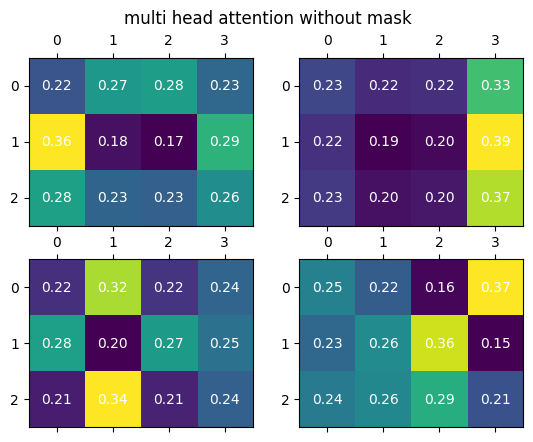

In [30]:
# 例子：创建一个子图网格，其维度由 outputs.attn_scores.shape[:2] 决定
# outputs.attn_scores.shape[:2] 代表 [batch_size, num_heads]
# 例如，如果 outputs.attn_scores 形状为 (2, 2, 3, 4)，则创建 2x2 的子图网格
fig, axis = plt.subplots(*outputs.attn_scores.shape[:2])

# 遍历 batch 维度（i 代表 batch_size）
for i in range(query.shape[0]):  # batch_size
    # 遍历多头注意力维度（j 代表 num_heads）
    for j in range(outputs.attn_scores.shape[1]):  # num_heads
        # 在 axis[i, j] 位置绘制当前头的注意力分数热图
        # outputs.attn_scores[i, j] 形状为 (seq_len, seq_len)
        # detach().numpy() 将 PyTorch 张量转换为 NumPy 数组，便于可视化
        axis[i, j].matshow(outputs.attn_scores[i, j].detach().numpy())

        # 遍历行 (query 序列长度)
        for x in range(outputs.attn_scores.shape[2]):  # seq_len (query)
            # 遍历列 (key 序列长度)
            for y in range(outputs.attn_scores.shape[3]):  # seq_len (key)
                # 在热图上添加文字，显示每个 (x, y) 位置的注意力分数
                # 格式化为两位小数，文本居中，并使用白色字体
                axis[i, j].text(
                    y, x, 
                    f"{outputs.attn_scores[i, j, x, y]:.2f}", 
                    ha="center", va="center", color="w"
                )

# 设置图表标题
fig.suptitle("multi head attention without mask")

# 显示图像
plt.show()

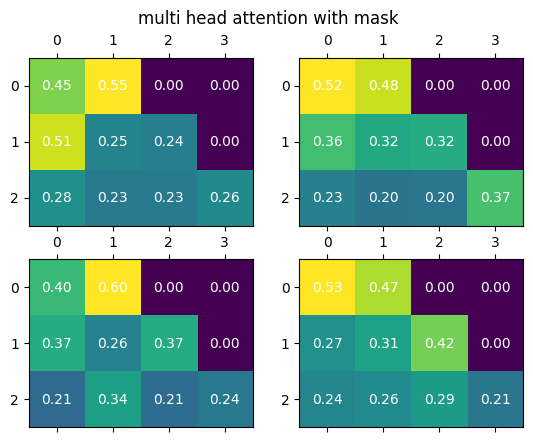

In [31]:
# 例子：构造一个手动指定的 Mask 矩阵
# 形状为 (1, 1, 3, 4)，用于屏蔽部分注意力权重
# 其中 1 代表被屏蔽（会被赋予 -∞ 值，使其 softmax 后趋近于 0）
mask = torch.Tensor([
    [0, 0, 1, 1],  # 第 1 行：屏蔽后两个位置
    [0, 0, 0, 1],  # 第 2 行：屏蔽最后一个位置
    [0, 0, 0, 0]   # 第 3 行：不过滤任何位置
]).reshape(1, 1, 3, 4)  # 形状调整为 (batch_size=1, num_heads=1, query_len=3, key_len=4)

# 进行带 Mask 的多头注意力计算
outputs_masked = mha(query, key_value, key_value, mask)

# 创建子图网格，其维度由 outputs_masked.attn_scores.shape[:2] 决定
# 对应 (batch_size, num_heads)
fig, axis = plt.subplots(*outputs_masked.attn_scores.shape[:2])

# 遍历 batch 维度（i 代表 batch_size）
for i in range(query.shape[0]):  # batch_size
    # 遍历多头注意力维度（j 代表 num_heads）
    for j in range(outputs_masked.attn_scores.shape[1]):  # num_heads
        # 绘制注意力分数热图（matshow 用于可视化矩阵）
        axis[i, j].matshow(outputs_masked.attn_scores[i, j].detach().numpy())

        # 遍历 query 维度（行数）
        for x in range(outputs_masked.attn_scores.shape[2]):  # seq_len (query)
            # 遍历 key 维度（列数）
            for y in range(outputs_masked.attn_scores.shape[3]):  # seq_len (key)
                # 在热图上叠加数值，格式化为两位小数
                axis[i, j].text(
                    y, x,
                    f"{outputs_masked.attn_scores[i, j, x, y]:.2f}",
                    ha="center", va="center", color="w"
                )

# 设置标题，标识该注意力计算使用了 Mask
fig.suptitle("multi head attention with mask")

# 显示图像
plt.show()

#### Transformer-Block

In [32]:
# @dataclass 装饰器：为TransformerBlockOutput类自动生成 __init__()、__repr__()、__eq__() 等方法。
@dataclass
class TransformerBlockOutput:
    # hidden_states: Tensor：表示当前块的输出（即隐藏状态），它包含了该块计算后的结果
    hidden_states: Tensor
    # self_attn_scores: Tensor：表示自注意力机制计算的注意力分数（self-attention scores）
    self_attn_scores: Tensor
    # cross_attn_scores: Optional[Tensor] = None：表示交叉注意力机制计算的注意力分数（cross-attention scores）。这个字段是可选的，只有在有交叉注意力时才会被使用。
    cross_attn_scores: Optional[Tensor] = None

# TransformerBlock 类，继承自 nn.Module，定义了一个标准的 Transformer 编码器块。
class TransformerBlock(nn.Module):
    def __init__(self, config, add_cross_attention=False):
        super().__init__()

        # 从配置中获取超参数
        self.hidden_size = config["d_model"]  # 模型的隐藏层大小
        self.num_heads = config["num_heads"]  # 多头注意力机制的头数
        dropout_rate = config["dropout"]  # dropout 的比例
        ffn_dim = config["dim_feedforward"]  # 前馈神经网络（FFN）的维度
        eps = config["layer_norm_eps"]  # 层归一化的 epsilon 值

        # 自注意力机制
        self.self_atten = MultiHeadAttention(config)  # 多头自注意力
        self.self_ln = nn.LayerNorm(self.hidden_size, eps=eps)  # 自注意力后的层归一化
        self.self_dropout = nn.Dropout(dropout_rate)  # 自注意力后的 dropout

        # 交叉注意力机制，仅在解码器中使用
        if add_cross_attention:
            self.cross_atten = MultiHeadAttention(config)  # 多头交叉注意力
            self.cross_ln = nn.LayerNorm(self.hidden_size, eps=eps)  # 交叉注意力后的层归一化
            self.cross_dropout = nn.Dropout(dropout_rate)  # 交叉注意力后的 dropout
        else:
            self.cross_atten = None  # 如果没有交叉注意力，则为 None

        # 前馈神经网络（FFN）
        self.ffn = nn.Sequential(
            nn.Linear(self.hidden_size, ffn_dim),  # 输入经过一个线性层
            nn.ReLU(),  # ReLU 激活函数
            nn.Linear(ffn_dim, self.hidden_size),  # 输出通过另一个线性层
        )
        self.ffn_ln = nn.LayerNorm(self.hidden_size, eps=eps)  # FFN 输出后的层归一化
        self.ffn_dropout = nn.Dropout(dropout_rate)  # FFN 输出后的 dropout

    def forward(
        self,
        hidden_states,
        attn_mask=None,
        encoder_outputs=None,
        cross_attn_mask=None,
    ):
        # 自注意力机制
        self_atten_output = self.self_atten(
            hidden_states, hidden_states, hidden_states, attn_mask
        )
        # self_atten_output 包含了 self_attn_scores 和 hidden_states
        self_embeds = self.self_ln(
            hidden_states + self.self_dropout(self_atten_output.hidden_states)
        )  # 多头注意力输出后进行残差连接和层归一化

        # 交叉注意力机制（仅在解码器中）
        if self.cross_atten is not None:
            assert encoder_outputs is not None  # 如果使用交叉注意力，必须传入 encoder 的输出
            cross_atten_output = self.cross_atten(
                self_embeds, encoder_outputs, encoder_outputs, cross_attn_mask
            )  # query 是 self_embeds，key 和 value 是 encoder_outputs
            cross_embeds = self.cross_ln(
                self_embeds + self.cross_dropout(cross_atten_output.hidden_states)
            )  # 交叉注意力输出后进行残差连接和层归一化

        # 前馈神经网络（FFN）
        embeds = cross_embeds if self.cross_atten is not None else self_embeds  # 如果有交叉注意力，则使用交叉注意力的输出；否则，使用自注意力输出
        ffn_output = self.ffn(embeds)  # 前馈神经网络
        embeds = self.ffn_ln(embeds + self.ffn_dropout(ffn_output))  # FFN 输出后进行残差连接和层归一化

        # 返回包含 hidden_states（最终输出）、self_attn_scores 和 cross_attn_scores 的结果
        return TransformerBlockOutput(
            hidden_states=embeds,
            self_attn_scores=self_atten_output.attn_scores,  # 返回自注意力的注意力分数
            cross_attn_scores=cross_atten_output.attn_scores if self.cross_atten is not None else None,  # 返回交叉注意力的注意力分数（如果有交叉注意力）
        )

#### Encoder

In [33]:
from typing import List

@dataclass # 定义一个dataclass类来存储TransformerEncoder的输出结果
class TransformerEncoderOutput:
    # 用于存储TransformerEncoder的输出结果，包含了：
    # 1. 最后一层的隐藏状态
    # 2. 每层的注意力分数，用于分析模型关注不同位置的程度。
    last_hidden_states: Tensor  # 最后一层的隐藏状态输出，包含了经过所有编码层后得到的上下文信息
    attn_scores: List[Tensor]   # 每层的自注意力分数，用于可视化模型在每一层的注意力分布

# https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
class TransformerEncoder(nn.Module):
    def __init__(self, config):
        # 初始化Transformer编码器
        super().__init__()
        
        # 从config中获取编码器的层数
        self.num_layers = config["num_encoder_layers"]  

        # 使用nn.ModuleList来创建一个包含多个TransformerBlock的列表
        # 每个TransformerBlock代表编码器中的一层
        # ModuleList是一个可以存储多个子模块（TransformerBlock）的容器
        # 在每一层中，输入会经过自注意力层和前馈神经网络层
        self.layers = nn.ModuleList(
            [TransformerBlock(config) for _ in range(self.num_layers)]  # 依据配置的层数创建每层TransformerBlock
        )

    def forward(
        self, encoder_inputs_embeds, attn_mask=None
    ) -> TransformerEncoderOutput:
        # 定义前向传播函数，encoder_inputs_embeds是输入的嵌入向量，通常是经过词嵌入和位置编码后的表示
        attn_scores = []  # 用于存储每一层计算得到的自注意力分数
        embeds = encoder_inputs_embeds  # 将输入的嵌入向量作为编码器的第一层输入

        # 遍历每一层的TransformerBlock
        for layer in self.layers:
            block_outputs = layer(embeds, attn_mask=attn_mask)  # 将输入传入当前层的TransformerBlock
            
            # 更新embeds为当前层输出的hidden_states
            # 作为下一层TransformerBlock的输入
            embeds = block_outputs.hidden_states 

            # 每层的注意力分数存储到attn_scores中
            # 这对于后续的可视化或调试非常有用
            attn_scores.append(block_outputs.self_attn_scores)  # 每层的自注意力分数

        # 返回最后一层的隐藏状态和所有层的注意力分数
        return TransformerEncoderOutput(
            last_hidden_states=embeds,  # 最后一层的输出作为最终的编码结果
            attn_scores=attn_scores  # 每层的自注意力分数
        )

#### Decoder

In [34]:
@dataclass
class TransformerDecoderOutput:
    # 用于存储TransformerDecoder的输出结果，包含：
    # 1. 最后一层的隐藏状态
    # 2. 每层的自注意力分数
    # 3. 每层的交叉注意力分数
    last_hidden_states: Tensor  # 最后一层的隐藏状态，包含了经过所有解码器层后得到的上下文信息
    self_attn_scores: List[Tensor]  # 每层的自注意力分数，用于分析解码器内部如何处理输入序列
    cross_attn_scores: List[Tensor]  # 每层的交叉注意力分数，用于分析解码器如何与编码器的输出进行交互

class TransformerDecoder(nn.Module):
    def __init__(self, config):
        # 初始化Transformer解码器
        super().__init__()
        
        # 从config中获取解码器的层数
        self.num_layers = config["num_decoder_layers"]  

        # 使用nn.ModuleList来创建一个包含多个TransformerBlock的列表
        # 每个TransformerBlock代表解码器中的一层
        # 在每一层中，输入会经过自注意力层和交叉注意力层，再经过前馈神经网络层
        self.layers = nn.ModuleList(
            [
                TransformerBlock(config, add_cross_attention=True)  # 解码器每层都有交叉注意力机制
                for _ in range(self.num_layers)  # 根据配置的层数创建每层TransformerBlock
            ]
        )

    def forward(self, decoder_inputs_embeds, encoder_outputs, attn_mask=None, cross_attn_mask=None,) -> TransformerDecoderOutput:
        # 定义前向传播函数，接受解码器的输入嵌入向量、编码器输出以及相应的注意力掩码
        self_attn_scores = []  # 用于存储每一层计算得到的自注意力分数
        cross_attn_scores = []  # 用于存储每一层计算得到的交叉注意力分数
        embeds = decoder_inputs_embeds  # 将解码器输入的嵌入向量作为第一层输入

        # 遍历每一层的TransformerBlock
        for layer in self.layers:
            # 通过当前的TransformerBlock进行前向传播
            block_outputs = layer(
                embeds,
                attn_mask=attn_mask,  # 自注意力的掩码，用于在注意力计算时屏蔽一些无关的位置
                encoder_outputs=encoder_outputs,  # 编码器的输出，用于交叉注意力
                cross_attn_mask=cross_attn_mask,  # 交叉注意力的掩码，用于屏蔽编码器的无关位置
            )
            # 更新embeds为当前层输出的hidden_states，作为下一层TransformerBlock的输入
            embeds = block_outputs.hidden_states 

            # 每层的自注意力分数存储到self_attn_scores列表中, 用于画图
            self_attn_scores.append(block_outputs.self_attn_scores)
            # 每层的交叉注意力分数存储到cross_attn_scores列表中, 用于画图
            cross_attn_scores.append(block_outputs.cross_attn_scores)

        # 返回最后一层的隐藏状态和每层的自注意力、交叉注意力分数
        return TransformerDecoderOutput(
            last_hidden_states=embeds,  # 最后一层的输出作为最终的解码器输出
            self_attn_scores=self_attn_scores,  # 每层的自注意力分数
            cross_attn_scores=cross_attn_scores,  # 每层的交叉注意力分数
        )

#### mask

- mask实际上大类上只有两种
    1. `padding_mask`：mask掉`pad_idx`，不计算损失
    2. `attention_mask`：mask掉`pad_idx`，不计算注意力分数
- Decoder的`attention_mask`和Encoder有一定的区别：
    - Encoder可以同时看见序列所有信息，故只mask掉`pad_idx`
    - Decoder只能看到在自身之前的序列的信息，故要额外mask掉自身之后的序列

In [35]:
# 例子： 生成下三角的pad_mask
(torch.triu(torch.ones(5, 5)) == 0).transpose(-1,-2)

tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])

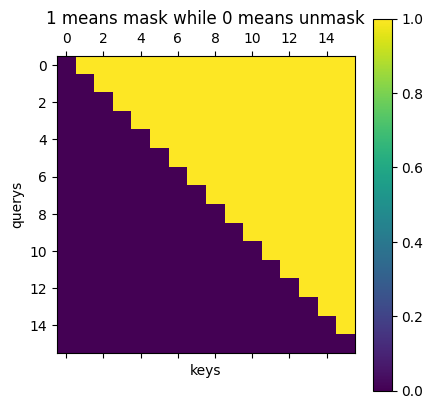

In [36]:
def generate_square_subsequent_mask(sz: int) -> Tensor:
    """
    生成一个方形的后续掩码（Subsequent Mask）。
    被屏蔽（mask）的部分填充为 True，未屏蔽的部分填充为 False。
    """
    # torch.ones(sz, sz): 创建一个 sz × sz 的全 1 矩阵
    # torch.triu(...): 取得上三角部分（主对角线以上部分为 1，以下部分为 0）
    mask = (torch.triu(torch.ones(sz, sz)) == 0).transpose(-1, -2).bool()
    
    return mask

plt.matshow(generate_square_subsequent_mask(16))  # 生成 16x16 的掩码并可视化
plt.colorbar()  # 显示颜色条
plt.xlabel("keys")  # x 轴代表键（key）
plt.ylabel("querys")  # y 轴代表查询（query）
plt.title("1 means mask while 0 means unmask")  # 标题：1 表示掩码，0 表示未被掩码
plt.show()  # 展示掩码矩阵

['[BOS]', '[UNK]', 'quick', 'brown', '[UNK]', 'jumps', 'over', 'the', '[UNK]', 'dog', '.', '[EOS]']


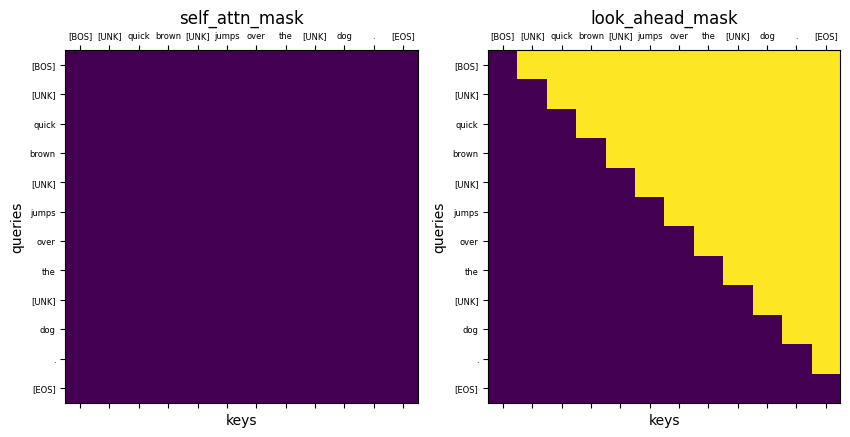

--------------------------------------------------
['[BOS]', '[UNK]', 'does', 'the', '[UNK]', 'say', '?', '[EOS]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


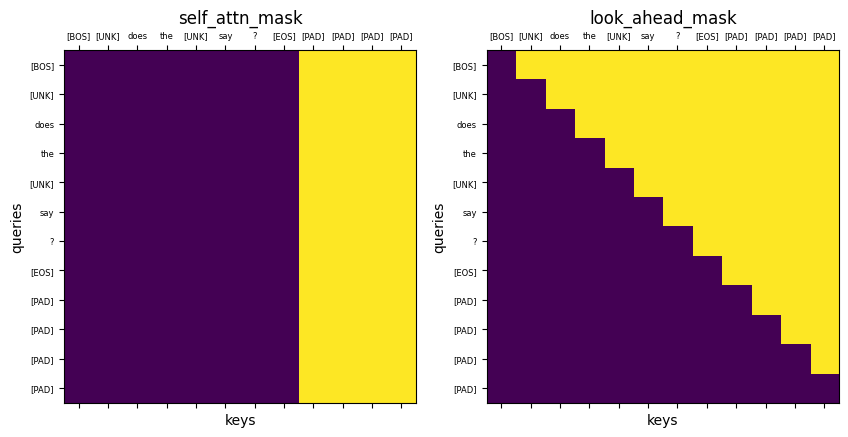

--------------------------------------------------


In [37]:
# 例子：通过下面代码查看 mask（掩码）的效果
# 输入的句子列表
inputs_words = [
    "The quick brown fox jumps over the lazy dog .",
    "What does the fox say ?"
]

# 使用 tokenizer 对输入的句子进行编码，同时返回 mask
# encode() 方法会将输入的文本转换为对应的 token ID，并返回相应的掩码（mask）
inputs_ids, input_mask = tokenizer.encode(
    [w.split() for w in inputs_words], return_mask=True
)

# 遍历每个输入句子，查看它们的编码和掩码效果
for i in range(len(inputs_words)):
    # 解码当前句子的 token ID，确保不会移除特殊 token（如BOS、EOS、PAD）
    decode_text = tokenizer.decode(
        inputs_ids[i: i+1].tolist(),
        remove_bos=False,  # 不移除句首（BOS）
        remove_eos=False,  # 不移除句尾（EOS）
        remove_pad=False,  # 不移除填充（PAD）
        split=True  # 以列表形式返回
    )[0]

    print(decode_text)  # 打印解码后的文本

    # 生成自注意力掩码（self_attn_mask）
    # input_mask[i] 形状为 (seq_len,)，先调整形状为 (1, seq_len)
    # 然后重复扩展 seq_len 次，使其变成 (seq_len, seq_len) 形状
    self_attn_mask = input_mask[i].reshape(1, -1).repeat_interleave(
        inputs_ids.shape[-1], dim=0
    )

    # 生成未来信息屏蔽掩码（look_ahead_mask）
    # 这是 Transformer 解码器中用于防止看到未来单词的掩码
    look_ahead_mask = generate_square_subsequent_mask(inputs_ids.shape[-1])

    # 绘制掩码矩阵的可视化
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 创建 1 行 2 列的子图

    # 绘制自注意力掩码（self-attention mask）
    axs[0].matshow(self_attn_mask)  # 绘制掩码矩阵
    axs[0].set_title("self_attn_mask")  # 设置标题
    axs[0].set_yticks(range(len(decode_text)), decode_text, fontsize=6)  # 设置 y 轴刻度
    axs[0].set_ylabel("queries")  # y 轴标签（查询）
    axs[0].set_xticks(range(len(decode_text)), decode_text, fontsize=6)  # 设置 x 轴刻度
    axs[0].set_xlabel("keys")  # x 轴标签（键）

    # 绘制未来信息屏蔽掩码（look-ahead mask）
    axs[1].matshow(look_ahead_mask)  # 绘制掩码矩阵
    axs[1].set_title("look_ahead_mask")  # 设置标题
    axs[1].set_yticks(range(len(decode_text)), decode_text, fontsize=6)  # 设置 y 轴刻度
    axs[1].set_ylabel("queries")  # y 轴标签（查询）
    axs[1].set_xticks(range(len(decode_text)), decode_text, fontsize=6)  # 设置 x 轴刻度
    axs[1].set_xlabel("keys")  # x 轴标签（键）

    plt.show()  # 显示图像

    print('-' * 50)  # 分隔符，方便阅读输出结果

In [38]:
# 例子：我随机两个[5, 1, 1, 4]与[1, 1, 4, 4]尺寸的张量，并求和
a = torch.randn(5, 1, 1, 4)
b = torch.randn(1, 1, 4, 4)
(a + b).shape

torch.Size([5, 1, 4, 4])

#### Transformer Model

In [39]:
@dataclass 
class TransformerOutput:
    logits: Tensor  # 预测的输出 logits，表示模型对每个词的概率分布
    encoder_last_hidden_states: Tensor  # 编码器的最终隐藏状态
    encoder_attn_scores: List[Tensor]  # 编码器的自注意力得分（用于可视化）
    decoder_last_hidden_states: Tensor  # 解码器的最终隐藏状态
    decoder_self_attn_scores: List[Tensor]  # 解码器的自注意力得分（用于可视化）
    decoder_cross_attn_scores: List[Tensor]  # 解码器的交叉注意力得分（用于可视化）
    preds: Optional[Tensor] = None  # 推理时的最终预测结果

class TransformerModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        # 超参数（Transformer的关键参数）
        self.hidden_size = config["d_model"]  # 模型的隐藏层大小
        self.num_encoder_layers = config["num_encoder_layers"]  # 编码器层数
        self.num_decoder_layers = config["num_decoder_layers"]  # 解码器层数
        self.pad_idx = config["pad_idx"]  # PAD标记索引
        self.bos_idx = config["bos_idx"]  # 句子起始标记索引
        self.eos_idx = config["eos_idx"]  # 句子结束标记索引
        self.vocab_size = config["vocab_size"]  # 词汇表大小
        self.dropout_rate = config["dropout"]  # dropout 比例
        self.max_length = config["max_length"]  # 生成的最大句子长度
        self.share = config["share_embedding"]  # 是否共享词嵌入

        # 词嵌入层
        self.src_embedding = TransformerEmbedding(config)  # 源语言嵌入层
        if self.share:  # 如果共享词嵌入，则目标语言的嵌入层与源语言相同
            self.trg_embedding = self.src_embedding  # 共享参数，节省内存
            self.linear = lambda x: torch.matmul(
                x, self.trg_embedding.get_word_embedding_weights().T
            )  # 输出层共享参数，使用嵌入矩阵的转置
        else:
            self.trg_embedding = TransformerEmbedding(config)  # 目标语言的嵌入层
            self.linear = nn.Linear(self.hidden_size, self.vocab_size)  # 独立的输出层

        # Transformer 编码器和解码器
        self.encoder = TransformerEncoder(config)
        self.decoder = TransformerDecoder(config)

        # 初始化权重
        self._init_weights()

    def _init_weights(self):
        """使用 Xavier 均匀分布初始化权重"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def generate_square_subsequent_mask(self, sz: int) -> Tensor:
        """
        生成一个下三角掩码矩阵（用于自回归解码）
        被掩码的位置填充 True，未掩码的位置填充 False
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 0).transpose(-1, -2).bool()
        return mask

    def forward(
        self, encoder_inputs, decoder_inputs, encoder_inputs_mask=None
    ) -> TransformerOutput:
        """
        Transformer 模型的前向传播
        encoder_inputs: [batch_size, src_len] 输入的源语言序列
        decoder_inputs: [batch_size, trg_len] 输入的目标语言序列
        encoder_inputs_mask: [batch_size, src_len] 源语言的掩码
        """
        if encoder_inputs_mask is None:
            encoder_inputs_mask = encoder_inputs.eq(self.pad_idx)  # [batch_size, src_len] pad 位置为 True
        encoder_inputs_mask = encoder_inputs_mask.unsqueeze(1).unsqueeze(2)  # 适配多头注意力的输入形状 [batch_size, 1, 1, src_len]

        # 生成解码器的掩码
        look_ahead_mask = self.generate_square_subsequent_mask(decoder_inputs.shape[1])
        look_ahead_mask = (
            look_ahead_mask.unsqueeze(0).unsqueeze(0).to(decoder_inputs.device)
        )  # 形状变换 [1, 1, trg_len, trg_len]
        decoder_inputs_mask = decoder_inputs.eq(self.pad_idx).unsqueeze(1).unsqueeze(2)  # [batch_size, 1, 1, trg_len]
        decoder_inputs_mask = decoder_inputs_mask + look_ahead_mask  # 组合两种掩码

        # 编码
        encoder_inputs_embeds = self.src_embedding(encoder_inputs)
        encoder_outputs = self.encoder(encoder_inputs_embeds, encoder_inputs_mask)

        # 解码
        decoder_inputs_embeds = self.trg_embedding(decoder_inputs)
        decoder_outputs = self.decoder(
            decoder_inputs_embeds=decoder_inputs_embeds,
            encoder_outputs=encoder_outputs.last_hidden_states,
            attn_mask=decoder_inputs_mask,
            cross_attn_mask=encoder_inputs_mask,
        )

        logits = self.linear(decoder_outputs.last_hidden_states)  # 计算最终输出的 logits

        return TransformerOutput(
            logits=logits,
            encoder_last_hidden_states=encoder_outputs.last_hidden_states,
            encoder_attn_scores=encoder_outputs.attn_scores,
            decoder_last_hidden_states=decoder_outputs.last_hidden_states,
            decoder_self_attn_scores=decoder_outputs.self_attn_scores,
            decoder_cross_attn_scores=decoder_outputs.cross_attn_scores,
        )

    @torch.no_grad()
    def infer(self, encoder_inputs, encoder_inputs_mask=None) -> Tensor:
        """ Transformer 推理 """
        if encoder_inputs_mask is None:
            encoder_inputs_mask = encoder_inputs.eq(self.pad_idx)
        encoder_inputs_mask = encoder_inputs_mask.unsqueeze(1).unsqueeze(2)
        look_ahead_mask = self.generate_square_subsequent_mask(self.max_length)
        look_ahead_mask = look_ahead_mask.unsqueeze(0).unsqueeze(0).to(encoder_inputs.device)

        # 编码过程
        encoder_inputs_embeds = self.src_embedding(encoder_inputs)
        encoder_outputs = self.encoder(encoder_inputs_embeds)

        # 解码过程（自回归）
        decoder_inputs = torch.Tensor([self.bos_idx] * encoder_inputs.shape[0]).reshape(-1, 1).long().to(device=encoder_inputs.device)
        for cur_len in tqdm(range(1, self.max_length + 1)):
            decoder_inputs_embeds = self.trg_embedding(decoder_inputs)
            decoder_outputs = self.decoder(
                decoder_inputs_embeds=decoder_inputs_embeds,
                encoder_outputs=encoder_outputs.last_hidden_states,
                attn_mask=look_ahead_mask[:, :, :cur_len, :cur_len],
            )
            logits = self.linear(decoder_outputs.last_hidden_states)
            next_token = logits.argmax(dim=-1)[:, -1:]
            decoder_inputs = torch.cat([decoder_inputs, next_token], dim=-1)
            if all((decoder_inputs == self.eos_idx).sum(dim=-1) > 0):
                break

        return TransformerOutput(
            preds=decoder_inputs[:, 1:],
            logits=logits,
            encoder_last_hidden_states=encoder_outputs.last_hidden_states,
            encoder_attn_scores=encoder_outputs.attn_scores,
            decoder_last_hidden_states=decoder_outputs.last_hidden_states,
            decoder_self_attn_scores=decoder_outputs.self_attn_scores,
            decoder_cross_attn_scores=decoder_outputs.cross_attn_scores,
        )

## 训练

### 损失函数

In [40]:
class CrossEntropyWithPadding:
    def __init__(self, config):
        # 初始化时读取配置中的标签平滑参数
        self.label_smoothing = config["label_smoothing"]

    def __call__(self, logits, labels, padding_mask=None):
        # logits.shape = [batch size, sequence length, num of classes]
        # labels.shape = [batch size, sequence length]
        # padding_mask.shape = [batch size, sequence length]

        bs, seq_len, nc = logits.shape  # 获取批次大小、序列长度和类别数
        # 计算交叉熵损失
        # 将logits调整为[batch size * sequence length, num of classes]的形状
        # 将labels调整为一维，大小为[batch size * sequence length]
        # 如果有标签平滑，交叉熵损失会被平滑
        loss = F.cross_entropy(logits.reshape(bs * seq_len, nc), labels.reshape(-1), reduce=False, label_smoothing=self.label_smoothing)
        # 如果没有padding_mask，则直接返回平均损失
        if padding_mask is None:
            loss = loss.mean()
        else:
            # 如果有padding_mask，将其调整为一维张量，mask部分为0，非mask部分为1
            padding_mask = 1 - padding_mask.reshape(-1)
            # 对于非padding部分的损失进行加权求和
            # padding_mask为0的部分损失会被忽略，padding_mask为1的部分损失会参与计算
            loss = torch.mul(loss, padding_mask).sum() / padding_mask.sum()

        return loss  # 返回最终的损失值

### 学习率衰减

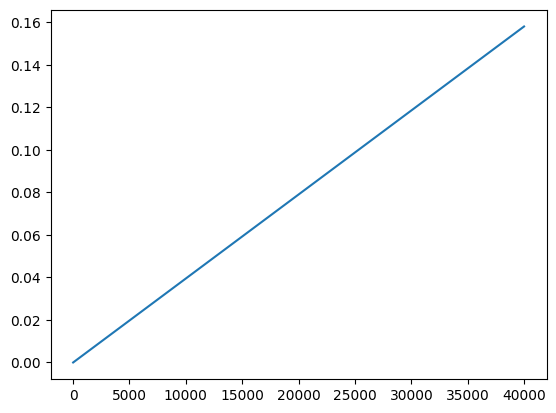

In [41]:
x=np.arange(1, 40000)
plt.plot(x, x * (4000 ** (-1.5)))

In [42]:
np.sqrt(512)

np.float64(22.627416997969522)

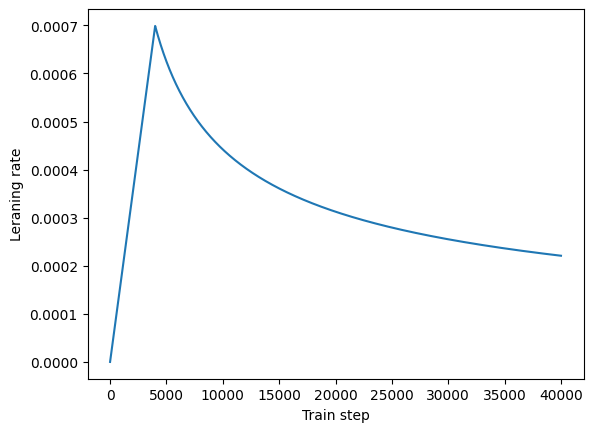

In [43]:
# NoamDecayScheduler 是一个自定义或外部定义的学习率衰减调度器类。它需要接收配置 config 作为参数，可能实现了特定的学习率衰减方案
class NoamDecayScheduler:
    def __init__(self, config):
        self.d_model = config["d_model"]
        self.warmup_steps = config["warmup_steps"]

    def __call__(self, step):
        step += 1
        arg1 = step ** (-0.5) #4000步之后是arg1
        arg2 = step * (self.warmup_steps ** (-1.5))  #4000步之前是arg2

        arg3 = self.d_model ** (-0.5)

        return arg3 * np.minimum(arg1, arg2)


temp_learning_rate_schedule = NoamDecayScheduler({"d_model": 512, "warmup_steps": 4000})
#下面是学习率的设计图
plt.plot(temp_learning_rate_schedule(np.arange(0, 40000)))
plt.ylabel("Leraning rate")
plt.xlabel("Train step")
plt.show()

### 优化器

In [44]:
from torch.optim.lr_scheduler import LambdaLR
from torch.optim import Adam

def get_optimizer(model, config):
    base_lr = 0.1
    beta1 = config["beta1"] # Adam 的 beta1
    beta2 = config["beta2"] # Adam 的 beta2
    eps = config["eps"]
    optimizer = Adam(model.parameters(), lr=base_lr, betas=(beta1, beta2), eps=eps)
    lr_scheduler = NoamDecayScheduler(config) #config是一个字典，包含了学习率衰减的参数
    # 使用 LambdaLR 调度器，它可以根据给定的函数 lr_lambda 调整学习率。这里将 lr_scheduler 作为函数传递给 LambdaLR，它包含了特定于模型或任务的学习率调度规则
    scheduler = LambdaLR(optimizer, lr_lambda=lr_scheduler)
    return optimizer, scheduler

### Callback

In [45]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)


In [46]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch.
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = - np.inf

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



In [47]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = - np.inf
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience


### training & valuating

In [48]:
@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    for batch in dataloader:
        encoder_inputs = batch["encoder_inputs"]
        encoder_inputs_mask = batch["encoder_inputs_mask"]
        decoder_inputs = batch["decoder_inputs"]
        decoder_labels = batch["decoder_labels"]
        decoder_labels_mask = batch["decoder_labels_mask"]

        # 前向计算
        outputs = model(
            encoder_inputs=encoder_inputs,
            decoder_inputs=decoder_inputs,
            encoder_inputs_mask=encoder_inputs_mask
            )
        logits = outputs.logits
        loss = loss_fct(logits, decoder_labels, padding_mask=decoder_labels_mask)         # 验证集损失
        loss_list.append(loss.cpu().item())

    return np.mean(loss_list)


In [49]:
# 训练
def training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    scheduler=None,
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 1
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for batch in train_loader:
                encoder_inputs = batch["encoder_inputs"]
                encoder_inputs_mask = batch["encoder_inputs_mask"]
                decoder_inputs = batch["decoder_inputs"]
                decoder_labels = batch["decoder_labels"]
                decoder_labels_mask = batch["decoder_labels_mask"]
                # 梯度清空
                optimizer.zero_grad()

                # 前向计算
                outputs = model(
                    encoder_inputs=encoder_inputs,
                    decoder_inputs=decoder_inputs,
                    encoder_inputs_mask=encoder_inputs_mask
                    )
                logits = outputs.logits
                loss = loss_fct(logits, decoder_labels, padding_mask=decoder_labels_mask)

                # 梯度回传
                loss.backward()

                # 调整优化器，包括学习率的变动等
                optimizer.step()
                if scheduler is not None:
                    scheduler.step() # 更新学习率

                loss = loss.cpu().item()
                # record
                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "step": global_step
                    })
                    model.train()

                    # 1. 使用 tensorboard 可视化
                    cur_lr = optimizer.param_groups[0]["lr"] if scheduler is None else scheduler.get_last_lr()[0]
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            lr=cur_lr,
                            )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=-val_loss)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(-val_loss)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
            pbar.set_postfix({"epoch": epoch_id, "loss": loss, "val_loss": val_loss})

    return record_dict


In [50]:
# 配置模型的超参数
config = {
    "bos_idx": 1,  # 句子起始标记 (Beginning of Sentence)
    "eos_idx": 3,  # 句子结束标记 (End of Sentence)
    "pad_idx": 0,  # 填充标记 (Padding Index)
    "vocab_size": len(word2idx),  # 词汇表大小
    "max_length": 128,  # 句子最大长度
    "d_model": 512,  # Transformer 词向量的维度
    "dim_feedforward": 2048,  # 前馈神经网络（FFN）的隐藏层大小
    "dropout": 0.1,  # dropout 率，用于防止过拟合
    "layer_norm_eps": 1e-6,  # 层归一化 (Layer Normalization) 时的 epsilon，防止除零错误
    "num_heads": 8,  # 多头注意力机制的头数
    "num_decoder_layers": 6,  # 解码器层数
    "num_encoder_layers": 6,  # 编码器层数
    "label_smoothing": 0.1,  # 交叉熵损失中的标签平滑系数
    "beta1": 0.9,  # Adam 优化器的 beta1 参数（用于一阶矩估计）
    "beta2": 0.98,  # Adam 优化器的 beta2 参数（用于二阶矩估计）
    "eps": 1e-9,  # Adam 优化器的 epsilon，防止除零错误
    "warmup_steps": 4_000,  # 学习率预热步数
    "share_embedding": False,  # 是否在编码器和解码器之间共享词向量
}

def get_dl(dataset, batch_size, shuffle=True):
    """
    获取数据加载器 (DataLoader)

    参数：
    dataset: 训练或验证数据集
    batch_size: 批次大小
    shuffle: 是否对批次进行随机排序（默认 True）

    返回：
    DataLoader 对象
    """
    # 使用 Transformer 任务自定义的批次采样器，确保 batch 内的句子长度一致
    sampler = TransformerBatchSampler(dataset, batch_size=batch_size, shuffle_batch=shuffle)
    # 使用 DataLoader 进行数据加载，collate_fn 用于处理不同长度的句子
    sample_dl = DataLoader(dataset, batch_sampler=sampler, collate_fn=partial(collate_fct, tokenizer=tokenizer))
    return sample_dl

# 构建训练集和验证集
train_ds = LangPairDataset("train", max_length=config["max_length"])  # 训练数据集
val_ds = LangPairDataset("val", max_length=config["max_length"])  # 验证数据集

# 构建分词器（Tokenizer），用于将文本转换为索引
tokenizer = Tokenizer(word2idx=word2idx, idx2word=idx2word, max_length=config["max_length"])

# 训练的批次大小
batch_size = 2048

# 创建数据加载器
train_dl = get_dl(train_ds, batch_size=batch_size, shuffle=True)  # 训练数据加载器
val_dl = get_dl(val_ds, batch_size=batch_size, shuffle=False)  # 验证数据加载器

load train dataset from wmt16\.cache\de2en_train_128.npy
load val dataset from wmt16\.cache\de2en_val_128.npy


In [51]:
#计算模型参数量
model = TransformerModel(config)
print(f"模型参数量: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

模型参数量: 71938239


In [52]:
config

{'bos_idx': 1,
 'eos_idx': 3,
 'pad_idx': 0,
 'vocab_size': 18111,
 'max_length': 128,
 'd_model': 512,
 'dim_feedforward': 2048,
 'dropout': 0.1,
 'layer_norm_eps': 1e-06,
 'num_heads': 8,
 'num_decoder_layers': 6,
 'num_encoder_layers': 6,
 'label_smoothing': 0.1,
 'beta1': 0.9,
 'beta2': 0.98,
 'eps': 1e-09,
 'warmup_steps': 4000,
 'share_embedding': False}

In [53]:
epoch = 20

# model
model = TransformerModel(config)
# 1. 定义损失函数 采用交叉熵损失
loss_fct = CrossEntropyWithPadding(config)
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer, scheduler = get_optimizer(model, config)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
exp_name = "translate-transformer-{}".format("share" if config["share_embedding"] else "not-share")
tensorboard_callback = TensorBoardCallback(f"runs/{exp_name}")
# tensorboard_callback.draw_model(model, [1, MAX_LENGTH])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback(
    f"checkpoints/{exp_name}", save_step=500, save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=8)

model = model.to(device)

In [55]:
record = training(
    model,
    train_dl,
    val_dl,
    epoch,
    loss_fct,
    optimizer,
    scheduler,
    tensorboard_callback=tensorboard_callback,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=None,
    eval_step=500
    )

# Training took 3.5 days on 8 P100 GPUs
# We trained the base models for a total of 100,000 steps or 12 hours. For our big models,(described on the bottom line of table 3), step time was 1.0 seconds. The big models were trained for 300,000 steps (3.5 days).

  0%|          | 0/280 [00:00<?, ?it/s]

C:\Program Files\Python312\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


KeyboardInterrupt: 

## 推理

- 翻译项目的评估指标一般是BLEU4，感兴趣的同学自行了解并实现
- 接下来进行翻译推理，并作出注意力的热度图

In [3]:
# !pip install Cython  # if failed to install fastBPE, try this line
# !pip install fastBPE #分词使用
# 在 Windows 系统上并没有 sys/mman.h 文件

Defaulting to user installation because normal site-packages is not writeable
  Using cached fastBPE-0.1.0.tar.gz (35 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for fastBPE
Failed to build fastBPE


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [6 lines of output]
  running bdist_wheel
  running build
  running build_py
  running build_ext
  building 'fastBPE' extension
  error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fastBPE
ERROR: Could not build wheels for fastBPE, which is required to install pyproject.toml-based projects

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [54]:
exp_name

'translate-transformer-not-share'

In [55]:
import torch

state_dict = torch.load(f"checkpoints/{exp_name}/best.ckpt", map_location="cpu")

# state_dict1 = torch.load("epoch125-step132426.ckpt", map_location="cpu")
# state_dict = state_dict1["state_dict"]

# update keys by dropping `model`
# for key in list(state_dict):
#     state_dict[key.replace("model.", "")] = state_dict.pop(key)


In [52]:
# !pip install nltk

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/a6/0a/0d20d2c0f16be91b9fa32a77b76c60f9baf6eba419e5ef5deca17af9c582/nltk-3.8.1-py3-none-any.whl (1.5 MB)



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [56]:
!rm -r wmt16/.cache

'rm' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [57]:
tokenizer.decode([[   5,   16,    6,   23,  150,   80, 8248,   35,  232,    4,    3]])

['a man in an seinem hat sh-@@ at guitar .']

In [58]:
from nltk.translate.bleu_score import sentence_bleu

# 加载 Transformer 模型
model = TransformerModel(config)  # 初始化 Transformer 模型
model.load_state_dict(state_dict)  # 加载预训练模型的参数

# 定义损失函数（交叉熵损失，带有标签平滑）
loss_fct = CrossEntropyWithPadding(config)

# 加载测试数据集
test_ds = LangPairDataset("test", max_length=128, data_dir="./wmt16")  # 测试数据集
test_dl = DataLoader(test_ds, batch_size=1, collate_fn=partial(collate_fct, tokenizer=tokenizer))  # 数据加载器

# 迁移模型到计算设备（CPU/GPU）
model = model.to(device)
model.eval()  # 设置模型为评估模式，防止 dropout 或 batchnorm 影响推理

# 定义数据收集字典
collect = {}  # 用于存储测试集中的样本及其损失
loss_collect = []  # 用于收集所有样本的损失

predictions = []  # 存储所有预测结果
answers = []  # 存储所有真实标签
bleu_scores = []  # 存储 BLEU 评分

# 遍历测试集
for idx, batch in tqdm(enumerate(test_dl)):
    encoder_inputs = batch["encoder_inputs"]  # 编码器输入（源语言）
    encoder_inputs_mask = batch["encoder_inputs_mask"]  # 源输入的填充掩码
    decoder_inputs = batch["decoder_inputs"]  # 解码器输入（目标语言）
    decoder_labels = batch["decoder_labels"]  # 目标真实标签（用于计算损失）

    # 进行前向传播，获取 Transformer 输出
    outputs = model(
        encoder_inputs=encoder_inputs,
        decoder_inputs=decoder_inputs,
        encoder_inputs_mask=encoder_inputs_mask
    )

    # 计算交叉熵损失
    loss = loss_fct(outputs.logits, decoder_labels)

    # 获取预测结果：取每个时间步上最大概率的词索引
    preds = outputs.logits.argmax(dim=-1)  # 预测序列形状为 [1, seq_len]

    # 将预测索引转换为实际的文本句子
    preds = tokenizer.decode(preds.cpu().numpy())  # ['预测句子']
    
    # 将真实标签转换为文本句子
    decoder_labels = tokenizer.decode(decoder_labels.cpu().numpy())  # ['标签句子']

    # 计算 BLEU 评分，使用 1-gram 计算精确匹配
    bleu = sentence_bleu([decoder_labels[0].split()], preds[0].split(), weights=(1, 0, 0, 0))
    bleu_scores.append(bleu)  # 存储 BLEU 分数

    # 记录样本信息，包括损失、输入、目标、预测
    collect[idx] = {
        "loss": loss.item(),  # 当前样本的损失
        "src_inputs": encoder_inputs,  # 源语言输入
        "trg_inputs": decoder_inputs,  # 目标语言输入
        "mask": encoder_inputs_mask,  # 源语言的填充掩码
        "trg_labels": decoder_labels,  # 真实目标文本
        "preds": preds  # 预测文本
    }

    # 记录损失
    loss_collect.append(loss.item())

# 按照损失大小对收集的数据进行排序（从低到高）
collect = sorted(collect.items(), key=lambda x: x[1]["loss"])

# 输出测试集平均损失
print(f"testing loss: {np.array(loss_collect).mean()}")

# 计算测试集的平均 BLEU 评分
print(f"Average BLEU score: {sum(bleu_scores) / len(bleu_scores)}")

save cache to wmt16\.cache\de2en_test_128.npy


0it [00:00, ?it/s]

C:\Program Files\Python312\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
C:\Program Files\Python312\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Program Files\Python312\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Program Files\Python312\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis cont

KeyboardInterrupt: 

In [60]:
import re
from fastBPE import fastBPE
from sacremoses import MosesDetokenizer, MosesTokenizer
import torch
import matplotlib.pyplot as plt

# `MosesTokenizer` 和 `MosesDetokenizer` 来自 `sacremoses` 库，主要用于自然语言处理中的分词（Tokenization）和去标记化（Detokenization）。
# `fastBPE` 用于执行 Byte Pair Encoding（BPE）分词技术，在神经机器翻译和 NLP 任务中非常常见。

class Translator:
    def __init__(self, model, src_tokenizer, trg_tokenizer):
        """
        初始化翻译器类，包含 BPE 处理、分词、去标记化和模型推理功能。

        参数：
        - model: Transformer 模型对象，用于执行翻译推理
        - src_tokenizer: 源语言的分词器
        - trg_tokenizer: 目标语言的分词器
        """
        # 初始化 BPE 处理器，加载预训练的 BPE 词汇表
        self.bpe = fastBPE("./wmt16/bpe.20000", "./wmt16/vocab")
        # 初始化 Moses 分词器（源语言为德语 "de"）
        self.mose_tokenizer = MosesTokenizer(lang="de")
        # 初始化 Moses 去标记化工具（目标语言为英语 "en"）
        self.mose_detokenizer = MosesDetokenizer(lang="en")
        # 存储模型并设置为评估模式
        self.model = model
        self.model.eval()
        # 存储源语言和目标语言的分词器
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer
        # 正则表达式，用于移除 BPE 生成的 `@@` 标记
        self.pattern = re.compile(r'(@@ )|(@@ ?$)')

    def draw_attention_map(self, attn_scores, cross_attn_scores, src_words_list, trg_words_list):
        """
        绘制 Transformer 模型的注意力（Attention）热力图，包括自注意力和交叉注意力。

        参数：
        - attn_scores: 自注意力分数（形状：[num_heads, trg_len, trg_len]）
        - cross_attn_scores: 交叉注意力分数（形状：[num_heads, trg_len, src_len]）
        - src_words_list: 源语言单词列表
        - trg_words_list: 目标语言单词列表
        """
        # 确保输入张量具有正确的形状
        assert len(attn_scores.shape) == 3, f"attn_scores 形状应为 [num_heads, trg_len, trg_len]，但得到了 {attn_scores.shape}"
        attn_scores = attn_scores[:, :len(trg_words_list), :len(trg_words_list)]
        assert len(cross_attn_scores.shape) == 3, f"cross_attn_scores 形状应为 [num_heads, trg_len, src_len]，但得到了 {cross_attn_scores.shape}"
        cross_attn_scores = cross_attn_scores[:, :len(trg_words_list), :len(src_words_list)]

        num_heads, trg_len, src_len = cross_attn_scores.shape

        # 创建一个 10x5 的绘图窗口，并自动调整子图布局
        fig = plt.figure(figsize=(10, 5), constrained_layout=True)
        grid = plt.GridSpec(trg_len, trg_len + src_len, wspace=0.1, hspace=0.1)

        # 自注意力热力图
        self_map = fig.add_subplot(grid[:, :trg_len])
        self_map.matshow(attn_scores.mean(dim=0), cmap='viridis')
        self_map.set_yticks(range(trg_len), trg_words_list, fontsize=10)
        self_map.set_xticks(range(trg_len), ["[BOS]"] + trg_words_list[:-1], rotation=90)

        # 交叉注意力热力图
        cross_map = fig.add_subplot(grid[:, trg_len:])
        cross_map.matshow(cross_attn_scores.mean(dim=0), cmap='viridis')
        cross_map.set_yticks(range(trg_len), [])
        cross_map.set_xticks(range(src_len), src_words_list, rotation=90)

        plt.show()

    def __call__(self, sentence_list, heads_list=None, layer_idx=-1):
        """
        执行翻译任务，并可选地绘制注意力热力图。

        参数：
        - sentence_list: 需要翻译的源语言句子列表
        - heads_list: 选择要可视化的注意力头列表（可选）
        - layer_idx: 选择可视化 Transformer 的哪一层（默认 -1，即最后一层）

        返回：
        - 翻译后的目标语言句子列表
        """
        # 将句子转换为小写并进行分词
        sentence_list = [" ".join(self.mose_tokenizer.tokenize(s.lower())) for s in sentence_list]
        # 进行 BPE 编码
        tokens_list = [s.split() for s in self.bpe.apply(sentence_list)]
        # 编码输入序列，并添加起始标记 ([BOS]) 和结束标记 ([EOS])
        encoder_input, attn_mask = self.src_tokenizer.encode(
            tokens_list,
            add_bos=True,
            add_eos=True,
            return_mask=True,
        )
        # 将编码后的输入转换为 PyTorch 张量
        encoder_input = torch.Tensor(encoder_input).to(dtype=torch.int64)
        # 使用 Transformer 模型进行推理
        outputs = self.model.infer(encoder_inputs=encoder_input, encoder_inputs_mask=attn_mask)

        preds = outputs.preds.numpy()
        # 解码目标语言句子
        trg_decoded = self.trg_tokenizer.decode(preds, split=True, remove_eos=False, remove_bos=False, remove_pad=False)
        # 解码源语言句子
        src_decoded = self.src_tokenizer.decode(
            encoder_input.numpy(),
            split=True,
            remove_bos=False,
            remove_eos=False
        )

        # 绘制注意力热力图
        for attn_score, cross_attn_score, src, trg in zip(
            outputs.decoder_self_attn_scores[layer_idx], outputs.decoder_cross_attn_scores[layer_idx], src_decoded, trg_decoded
        ):
            if heads_list is None:
                self.draw_attention_map(attn_score, cross_attn_score, src, trg)
            else:
                self.draw_attention_maps(attn_score, cross_attn_score, src, trg, heads_list=heads_list)

        # 返回翻译结果，并去除 BPE 标记
        return [self.mose_detokenizer.tokenize(self.pattern.sub("", s).split()) for s in self.trg_tokenizer.decode(preds)]

# 示例输入句子列表（德语）
sentence_list = [
    "Mann in einem kleinen weißen Boot auf einem See.",  # "Man in a small white boat on a lake."
]

 # "Ein Mann mit einem Eimer und ein Mädchen mit einem Hut am Strand.", # A man with a bucket and a girl in a hat on the beach.
# "Drei Männer auf Pferden während eines Rennens.",  # Three men on horses during a race.
# "Ein Mann und eine Frau essen zu Abend",  # 一个男人和一个女人在吃晚餐

# 加载 Transformer 模型
model = TransformerModel(config)
model.load_state_dict(state_dict)

# 初始化 Translator 对象
translator = Translator(model.cpu(), tokenizer, tokenizer)

# 执行翻译
translator(sentence_list, layer_idx=-1)

ModuleNotFoundError: No module named 'fastBPE'

In [ ]:
!ls checkpoints

translate-transformer-not-share


In [ ]:
# prompt: 把best.ckpt复制到云盘内
# !cp -r checkpoints/translate-transformer-not-share/best.ckpt /content/drive/MyDrive/transformer-de-en